https://stackoverflow.com/questions/50506347/operation-along-year-with-xarray

In the below link: Organizing daily Excel data into xarray dataset  (There is a nice 3-D figure represents the N-Data array)

https://stackoverflow.com/questions/41904951/organizing-daily-excel-data-into-xarray-dataset

https://medium.com/pangeo/step-by-step-guide-to-building-a-big-data-portal-e262af1c2977

https://stackoverflow.com/questions/40544846/read-multiple-coordinates-with-xarray

http://stephanhoyer.com/2015/06/11/xray-dask-out-of-core-labeled-arrays/

You might pass your data off to pandas for further analysis in tabular form: https://xray.readthedocs.io/en/stable/pandas.html

http://stephanhoyer.com/2015/06/11/xray-dask-out-of-core-labeled-arrays/#fn:1

For distributed computation that lets us automatically parallelize grouped operations written like:

s.groupby('some variable').apply(f),  where f is a function on NumPy arrays.


In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import xarray as xr
import datetime as dt
import matplotlib.pyplot as plt
import pvlib
# from pvlib.forecast import GFS, NAM, NDFD, HRRR, RAP

In [6]:
###http://stephanhoyer.com/2015/06/11/xray-dask-out-of-core-labeled-arrays/

# ds=xr.open_dataset('Hokk_Ens_Aggreg_S1_S2_2017_2018.nc')  #This data with latitude=43

# ds=xr.open_dataset('Hokk_Ens_Agg_lat42_44_12vars_2016.nc')  #This data with latitude=43

# ds=xr.open_dataset('Hokk_Ens_Agg_lat42_44_2017_2018.nc')  #This data with latitude ranges 42-44

# ds=xr.open_dataset('Hokk_Ens_Agg_lat42_44_inclHR_2016.nc')#latitude ranges 42-44, but unfortunately no HR not exist

# ds=xr.open_dataset('Hokk_Ens_Agg_lat42_44_inclHR_2017_18.nc')#atitude ranges 42-44 #latitude ranges 42-44, but unfortunately no HR not exist

ds=xr.open_dataset('Hokk_Ens_Agg_lat42_44_Jan2019_3vars_exist.nc')#For Jan 2019, by March 12, 2019 from ERA data at CDS only 3 variables available


# ds.sel(time='2017-1-1').max(['latitude', 'longitude']) 

# ds.sel(time='2016-1-1').max(['latitude', 'longitude'])


ds

<xarray.Dataset>
Dimensions:    (latitude: 5, longitude: 9, number: 10, time: 3)
Coordinates:
  * longitude  (longitude) float32 141.0 141.5 142.0 142.5 ... 144.0 144.5 145.0
  * latitude   (latitude) float32 44.0 43.5 43.0 42.5 42.0
  * number     (number) int32 0 1 2 3 4 5 6 7 8 9
  * time       (time) datetime64[ns] 2019-01-01 ... 2019-01-01T06:00:00
Data variables:
    ssrdc      (time, number, latitude, longitude) float32 ...
    ssrd       (time, number, latitude, longitude) float32 ...
    tp         (time, number, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2019-03-12 12:56:46 GMT by grib_to_netcdf-2.10.0: /opt/ecmw...

# Data Variables:
"10m_u_component_of_wind", "10m_v_component_of_wind", "2m_temperature", "snow_albedo", "snow_depth", "surface_solar_radiation_downward_clear_sky", "surface_solar_radiation_downwards", "total_cloud_cover", "total_column_cloud_ice_water", "total_column_cloud_liquid_water", "total_precipitation"

Data variables, they are described with their units as in: https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=overview

https://cds.climate.copernicus.eu/cdsapp#!/yourrequests?tab=form

https://apps.ecmwf.int/codes/grib/param-db  (to know which variables with accumulated values)

In [18]:
vars=['u10', 'v10', 't2m', 'asn', 'sd', 'ssrdc', 'ssrd', 'tcc', 'tciw', 'tclw', 'tp']
len(vars)

11

In [8]:
var_ens = xr.concat([ds[vars]], dim = 'number')
aggreg_ens=var_ens.groupby('time').mean(xr.ALL_DIMS)
aggreg_ens=aggreg_ens.to_dataframe()

KeyError: 'u10'

In [9]:
aggreg_ens.head()
# aggreg_ens.describe()

,u10,v10,t2m,asn,sd,ssrdc,ssrd,tcc,tciw,tclw,tp
time,,,,,,,,,,,
2016-01-01 00:00:00,3.886250,-2.851480,269.501862,0.827843,0.015721,8.118321e+05,7.034049e+05,0.485168,0.011588,0.002629,0.000096
2016-01-01 03:00:00,4.932747,-4.198853,271.775543,0.827589,0.015767,3.977169e+06,3.442835e+06,0.751851,0.028697,0.006843,0.000118
2016-01-01 06:00:00,4.844539,-3.502080,271.486176,0.827372,0.015781,3.176268e+06,2.446900e+06,0.836149,0.016325,0.016921,0.000110
2016-01-01 09:00:00,4.449503,-2.028370,270.332581,0.826932,0.015789,1.810985e+05,1.316305e+05,0.660479,0.010685,0.025483,0.000062
2016-01-01 12:00:00,3.681740,-0.185882,269.666321,0.828510,0.015821,0.000000e+00,0.000000e+00,0.634584,0.010211,0.019844,0.000064


In [10]:
from pvlib.forecast import GFS
model = GFS()
t2m_c = model.kelvin_to_celsius(aggreg_ens['t2m'])
aggreg_ens['t2m']=t2m_c
t2m_c.describe()

C:\Users\Mhdella\Anaconda3\lib\site-packages\pvlib\forecast.py:21: UserWarning: The forecast module algorithms and features are highly experimental. The API may change, the functionality may be consolidated into an io module, or the module may be separated into its own package.
  'The API may change, the functionality may be consolidated into an io ' +


count    2928.000000
mean        7.229512
std         9.265486
min       -11.694916
25%        -0.695473
50%         7.025543
75%        15.426987
max        25.473907
Name: t2m, dtype: float64

In [11]:
dw=aggreg_ens[['u10', 'v10']]
dw= {'wind_speed_u': aggreg_ens['u10'], 
     'wind_speed_v': aggreg_ens[ 'v10']}
aggreg_ens['wind_speed'] = model.uv_to_speed(dw)
aggreg_ens['wind_speed'].describe()

count    2928.000000
mean        4.090322
std         2.086712
min         0.051147
25%         2.574793
50%         3.833834
75%         5.340077
max        12.292839
Name: wind_speed, dtype: float64

In [12]:
aggreg_ens.head()

,u10,v10,t2m,asn,sd,ssrdc,ssrd,tcc,tciw,tclw,tp,wind_speed
time,,,,,,,,,,,,
2016-01-01 00:00:00,3.886250,-2.851480,-3.648132,0.827843,0.015721,8.118321e+05,7.034049e+05,0.485168,0.011588,0.002629,0.000096,4.820153
2016-01-01 03:00:00,4.932747,-4.198853,-1.374451,0.827589,0.015767,3.977169e+06,3.442835e+06,0.751851,0.028697,0.006843,0.000118,6.477837
2016-01-01 06:00:00,4.844539,-3.502080,-1.663818,0.827372,0.015781,3.176268e+06,2.446900e+06,0.836149,0.016325,0.016921,0.000110,5.977803
2016-01-01 09:00:00,4.449503,-2.028370,-2.817413,0.826932,0.015789,1.810985e+05,1.316305e+05,0.660479,0.010685,0.025483,0.000062,4.890027
2016-01-01 12:00:00,3.681740,-0.185882,-3.483673,0.828510,0.015821,0.000000e+00,0.000000e+00,0.634584,0.010211,0.019844,0.000064,3.686430


In [13]:
resampled_data = aggreg_ens.resample('30min').interpolate()
resampled_data.head()
resampled_data.describe()

,u10,v10,t2m,asn,sd,ssrdc,ssrd,tcc,tciw,tclw,tp,wind_speed
count,17563.000000,17563.000000,17563.000000,17563.000000,1.756300e+04,1.756300e+04,17563.00,17563.000000,17563.000000,17563.000000,17563.000000,17563.000000
mean,1.428675,0.236202,7.232975,0.853095,1.339059e-02,2.333596e+06,1629395.25,0.669443,0.034991,0.071730,0.000494,4.090446
std,3.316600,2.781779,9.248779,0.032705,2.125720e-02,2.809504e+06,2134173.75,0.271435,0.057580,0.107472,0.001125,2.061110
min,-12.133279,-9.180594,-11.694916,0.724005,7.450581e-09,0.000000e+00,0.00,0.000487,0.000000,0.000003,0.000000,0.051147
25%,-1.049272,-1.580076,-0.760676,0.831412,7.450581e-09,0.000000e+00,0.00,0.464102,0.004372,0.004745,0.000029,2.585643
50%,1.373804,0.199983,6.962524,0.864956,2.302423e-04,8.320067e+05,532796.75,0.708392,0.014316,0.021403,0.000121,3.817842
75%,3.839105,2.296534,15.459869,0.880001,1.828497e-02,4.179901e+06,2763182.50,0.923425,0.034665,0.095017,0.000348,5.327740
max,11.793585,8.175369,25.473907,0.880003,7.442345e-02,9.844467e+06,9741109.00,1.000000,0.477273,0.787889,0.014894,12.292839


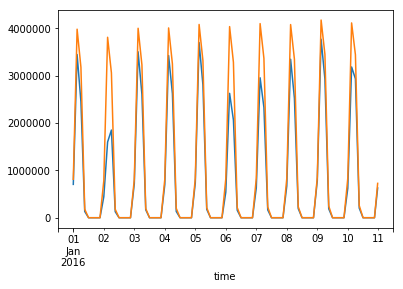

In [16]:
# df_plt=resampled_data.loc['2017-1-1':'2017-1-10']
df_plt=resampled_data.loc['2016-1-1':'2016-1-10']

df_plt['ssrd'].plot()
df_plt['ssrdc'].plot()

https://apps.ecmwf.int/codes/grib/param-db  (to know which variables with accumulated values)

https://confluence.ecmwf.int/pages/viewpage.action?pageId=111155330

These are the variables that attributed with accumulated fields:

"snow_depth", "surface_solar_radiation_downward_clear_sky", "surface_solar_radiation_downwards",  "total_precipitation"
vars=['sd', 'ssrdc', 'ssrd', 'tp']


In [17]:
df_acc=resampled_data[['ssrdc', 'ssrd']]
df_avg=df_acc/(3*3600)
# df_avg.head()
# df_acc
# 2017-01-01 00:00:00'
print(df_acc.head(9))
print(df_avg.head(9))

                            ssrdc          ssrd
time                                           
2016-01-01 00:00:00  8.118321e+05  7.034049e+05
2016-01-01 00:30:00  1.339388e+06  1.159977e+06
2016-01-01 01:00:00  1.866944e+06  1.616548e+06
2016-01-01 01:30:00  2.394500e+06  2.073120e+06
2016-01-01 02:00:00  2.922057e+06  2.529692e+06
2016-01-01 02:30:00  3.449613e+06  2.986263e+06
2016-01-01 03:00:00  3.977169e+06  3.442835e+06
2016-01-01 03:30:00  3.843686e+06  3.276846e+06
2016-01-01 04:00:00  3.710202e+06  3.110857e+06
                          ssrdc        ssrd
time                                       
2016-01-01 00:00:00   75.169632   65.130089
2016-01-01 00:30:00  124.017433  107.405243
2016-01-01 01:00:00  172.865219  149.680389
2016-01-01 01:30:00  221.713013  191.955551
2016-01-01 02:00:00  270.560822  234.230713
2016-01-01 02:30:00  319.408600  276.505859
2016-01-01 03:00:00  368.256378  318.781006
2016-01-01 03:30:00  355.896820  303.411652
2016-01-01 04:00:00  343.537231 

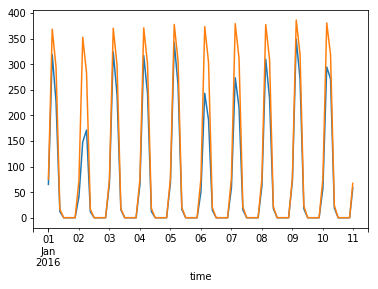

In [19]:
# df_plt=df_avg.loc['2017-1-1':'2017-1-10']
df_plt=df_avg.loc['2016-1-1':'2016-1-10']

df_plt['ssrd'].plot()
df_plt['ssrdc'].plot()

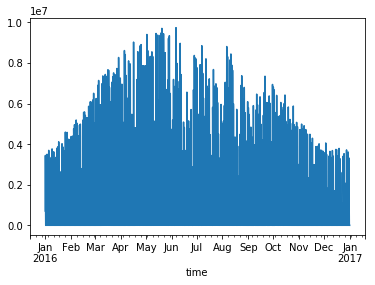

In [21]:
# df_plt=resampled_data['2017-1-1':'2018-12-31']
df_plt=resampled_data['2016-1-1':'2016-12-31']

df_plt['ssrd'].plot()
# df_plt['ssrdc'].plot()

In [22]:
resampled_data[['ssrdc', 'ssrd']]=df_avg
resampled_data.head(9)

,u10,v10,t2m,asn,sd,ssrdc,ssrd,tcc,tciw,tclw,tp,wind_speed
time,,,,,,,,,,,,
2016-01-01 00:00:00,3.886250,-2.851480,-3.648132,0.827843,0.015721,75.169632,65.130089,0.485168,0.011588,0.002629,0.000096,4.820153
2016-01-01 00:30:00,4.060666,-3.076042,-3.269185,0.827800,0.015729,124.017433,107.405243,0.529615,0.014439,0.003331,0.000100,5.096434
2016-01-01 01:00:00,4.235083,-3.300604,-2.890239,0.827758,0.015737,172.865219,149.680389,0.574062,0.017291,0.004034,0.000103,5.372715
2016-01-01 01:30:00,4.409499,-3.525166,-2.511292,0.827716,0.015744,221.713013,191.955551,0.618509,0.020142,0.004736,0.000107,5.648995
2016-01-01 02:00:00,4.583915,-3.749728,-2.132344,0.827674,0.015752,270.560822,234.230713,0.662956,0.022994,0.005438,0.000111,5.925275
2016-01-01 02:30:00,4.758331,-3.974291,-1.753398,0.827632,0.015759,319.408600,276.505859,0.707404,0.025845,0.006140,0.000115,6.201556
2016-01-01 03:00:00,4.932747,-4.198853,-1.374451,0.827589,0.015767,368.256378,318.781006,0.751851,0.028697,0.006843,0.000118,6.477837
2016-01-01 03:30:00,4.918046,-4.082724,-1.422679,0.827553,0.015769,355.896820,303.411652,0.765900,0.026635,0.008522,0.000117,6.394498
2016-01-01 04:00:00,4.903345,-3.966595,-1.470907,0.827517,0.015772,343.537231,288.042297,0.779950,0.024573,0.010202,0.000116,6.311159


In [23]:
# resampled_data.to_csv('Hokk_Ens_Aggreg_S1_S2_2017_2018.csv')

In [24]:
res_dx=pd.to_datetime(resampled_data.index.strftime('%Y-%m-%d %H:%M:%S'))
res_dx_utc=res_dx.tz_localize('UTC')
res_jp=res_dx_utc.tz_convert('Japan')
form_res_jp=res_jp.strftime('%Y-%m-%d %H:%M:%S')
# print(res_dx)
# print(res_dx_utc)
# print(res_jp)
# print(form_res_jp)

In [25]:
resampled_data.insert(0, 'DATE', res_jp.date)
resampled_data.insert(1, 'TIME', res_jp.time)

resampled_data.head()

,DATE,TIME,u10,v10,t2m,asn,sd,ssrdc,ssrd,tcc,tciw,tclw,tp,wind_speed
time,,,,,,,,,,,,,,
2016-01-01 00:00:00,2016-01-01,09:00:00,3.886250,-2.851480,-3.648132,0.827843,0.015721,75.169632,65.130089,0.485168,0.011588,0.002629,0.000096,4.820153
2016-01-01 00:30:00,2016-01-01,09:30:00,4.060666,-3.076042,-3.269185,0.827800,0.015729,124.017433,107.405243,0.529615,0.014439,0.003331,0.000100,5.096434
2016-01-01 01:00:00,2016-01-01,10:00:00,4.235083,-3.300604,-2.890239,0.827758,0.015737,172.865219,149.680389,0.574062,0.017291,0.004034,0.000103,5.372715
2016-01-01 01:30:00,2016-01-01,10:30:00,4.409499,-3.525166,-2.511292,0.827716,0.015744,221.713013,191.955551,0.618509,0.020142,0.004736,0.000107,5.648995
2016-01-01 02:00:00,2016-01-01,11:00:00,4.583915,-3.749728,-2.132344,0.827674,0.015752,270.560822,234.230713,0.662956,0.022994,0.005438,0.000111,5.925275


In [26]:
### resampled_data.to_csv('Hokk_Ens_Agg_Res_Jp_lat43_2017_18.csv')  #just 1 latitude 43
### resampled_data.to_csv('Hokk_Ens_Agg_Res_Jp_lat42_44_2017_18.csv') #here latitude ranges from 42-44
resampled_data.to_csv('Hokk_Ens_Agg_Res_Jp_lat42_44_2016.csv')  #just 1 latitude 43
